In [ ]:
%%capture
!pip install einops
!pip install torchmetrics
!pip install livelossplot
!pip install pybedtools
!pip install Bio
!pip install Sophia-Optimizer
!pip install memory_efficient_attention_pytorch
!pip install accelerate

In [ ]:
# !nvidia-smi

In [ ]:
# CUDA_LAUNCH_BLOCKING="1"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [ ]:
import os

os.getpid()
from functools import partial
from scipy.stats import zscore
import torch
import copy
import itertools
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
from IPython.display import display
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.modules.activation import ReLU
from torch.optim import Adam
from tqdm import tqdm_notebook
from torchvision.utils import save_image
import matplotlib
import math
from inspect import isfunction
from functools import partial
import scipy
from scipy.special import rel_entr
from torch import nn, einsum
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from torch import nn, einsum
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.animation as animation
import matplotlib.image as mpimg
import glob
from PIL import Image
from typing import List, Union
from torchmetrics.functional import kl_divergence
import random
import gc
from livelossplot import PlotLosses
from Bio import SeqIO
import pandas as pd
import math
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import Tensor
from torch.optim.optimizer import Optimizer
from memory_efficient_attention_pytorch import Attention
from accelerate import Accelerator
from typing import List, Optional
from collections import Counter
%matplotlib inline

# Optimizer

https://github.com/kyegomez/Sophia

In [ ]:
class SophiaG(Optimizer):
    """
    SophiaG optimizer class.
    """
    def __init__(self, params, lr=5e-2, betas=(0.965, 0.99), rho = 0.04,
         weight_decay=1e-1, *, maximize: bool = False,
         capturable: bool = False, dynamic: bool = False):
        """
        Initialize the optimizer.
        """
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if not 0.0 <= rho:
            raise ValueError(f"Invalid rho parameter at index 1: {rho}")
        if not 0.0 <= weight_decay:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")
        defaults = dict(lr=lr, betas=betas, rho=rho,
                        weight_decay=weight_decay,
                        maximize=maximize, capturable=capturable, dynamic=dynamic)
        super(SophiaG, self).__init__(params, defaults)

    def __setstate__(self, state):
        """
        Set the state of the optimizer.
        """
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('maximize', False)
            group.setdefault('capturable', False)
            group.setdefault('dynamic', False)
        state_values = list(self.state.values())
        step_is_tensor = (len(state_values) != 0) and torch.is_tensor(state_values[0]['step'])
        if not step_is_tensor:
            for s in state_values:
                s['step'] = torch.tensor(float(s['step']))

    @torch.no_grad()
    def update_hessian(self):
        """
        Update the hessian.
        """
        for group in self.param_groups:
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = torch.zeros((1,), dtype=torch.float, device=p.device) \
                        if self.defaults['capturable'] else torch.tensor(0.)
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                if 'hessian' not in state.keys():
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                state['hessian'].mul_(beta2).addcmul_(p.grad, p.grad, value=1 - beta2)

    @torch.no_grad()
    def update_exp_avg(self):
        """
        Update the exponential average.
        """
        for group in self.param_groups:
            beta1, beta2 = group['betas']
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]
                state['exp_avg'].mul_(beta1).add_(p.grad, alpha=1 - beta1)

    @torch.no_grad()
    def step(self, closure=None, bs=5120):
        """
        Perform a step of the optimizer.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        self.update_hessian()
        self.update_exp_avg()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            state_steps = []
            hessian = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is None:
                    continue
                params_with_grad.append(p)

                if p.grad.is_sparse:
                    raise RuntimeError('Hero does not support sparse gradients')
                grads.append(p.grad)
                state = self.state[p]
                # State initialization
                if len(state) == 0:
                    state['step'] = torch.zeros((1,), dtype=torch.float, device=p.device) \
                        if self.defaults['capturable'] else torch.tensor(0.)
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                if 'hessian' not in state.keys():
                    state['hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                exp_avgs.append(state['exp_avg'])
                state_steps.append(state['step'])
                hessian.append(state['hessian'])

                if self.defaults['capturable']:
                    bs = torch.ones((1,), dtype=torch.float, device=p.device) * bs

            self._sophiag(params_with_grad,
                  grads,
                  exp_avgs,
                  hessian,
                  state_steps,
                  bs=bs,
                  beta1=beta1,
                  beta2=beta2,
                  rho=group['rho'],
                  lr=group['lr'],
                  weight_decay=group['weight_decay'],
                  maximize=group['maximize'],
                  capturable=group['capturable'])

        return loss

    def _sophiag(self, params: List[Tensor],
          grads: List[Tensor],
          exp_avgs: List[Tensor],
          hessian: List[Tensor],
          state_steps: List[Tensor],
          capturable: bool = False,
          *,
          bs: int,
          beta1: float,
          beta2: float,
          rho: float,
          lr: float,
          weight_decay: float,
          maximize: bool):
        """
        SophiaG function.
        """
        if not all(isinstance(t, torch.Tensor) for t in state_steps):
            raise RuntimeError("API has changed, `state_steps` argument must contain a list of singleton tensors")

        self._single_tensor_sophiag(params,
             grads,
             exp_avgs,
             hessian,
             state_steps,
             bs=bs,
             beta1=beta1,
             beta2=beta2,
             rho=rho,
             lr=lr,
             weight_decay=weight_decay,
             maximize=maximize,
             capturable=capturable)

    def _single_tensor_sophiag(self, params: List[Tensor],
                         grads: List[Tensor],
                         exp_avgs: List[Tensor],
                         hessian: List[Tensor],
                         state_steps: List[Tensor],
                         *,
                         bs: int,
                         beta1: float,
                         beta2: float,
                         rho: float,
                         lr: float,
                         weight_decay: float,
                         maximize: bool,
                         capturable: bool):
        """
        SophiaG function for single tensor.
        """
        for i, param in enumerate(params):
            grad = grads[i] if not maximize else -grads[i]
            exp_avg = exp_avgs[i]
            hess = hessian[i]
            step_t = state_steps[i]

            if capturable:
                assert param.is_cuda and step_t.is_cuda and bs.is_cuda

            if torch.is_complex(param):
                grad = torch.view_as_real(grad)
                exp_avg = torch.view_as_real(exp_avg)
                hess = torch.view_as_real(hess)
                param = torch.view_as_real(param)

            # update step
            step_t += 1

            # Perform stepweight decay
            param.mul_(1 - lr * weight_decay)

            # Decay the first and second moment running average coefficient
            exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

            if capturable:
                step = step_t
                step_size = lr
                step_size_neg = step_size.neg()

                ratio = (exp_avg.abs() / (rho * bs * hess + 1e-15)).clamp(None,1)
                param.addcmul_(exp_avg.sign(), ratio, value=step_size_neg)
            else:
                step = step_t.item()
                step_size_neg = - lr

                ratio = (exp_avg.abs() / (rho * bs * hess + 1e-15)).clamp(None,1)
                param.addcmul_(exp_avg.sign(), ratio, value=step_size_neg)

#Params

https://github.com/pinellolab/DNA-Diffusion

In [ ]:
GLOBAL_SEED = 42
NUCLEOTIDES = ['A', 'C', 'T', 'G']
types = ["Z-DNA", "G-quad", "H-DNA"]
N_SAMPLES = 1000
EPOCHS = 10000
SEQ_SIZE = 50
CHANNELS = 1
LEARNING_RATE = 1e-5
TIMESTEPS = 100
RESNET_BLOCK_GROUPS = 4
BATCH_SIZE = 16
TOTAL_CLASS_NUMBER = 2
gradient_accumulation_steps = 8

In [ ]:
codes = {
 'A': [1., 0., 0., 0., 0.],
 'T': [0., 1., 0., 0., 0.],
 'G': [0., 0., 1., 0., 0.],
 'C': [0., 0., 0., 1., 0.],
 'N': [0., 0., 0., 0., 1.],
 }

#Functions

In [ ]:
def seed_everything(seed=GLOBAL_SEED):
    """ "
    Seed everything.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
def one_hot_encode(seq, nucleotides, max_seq_len):
    """
    One-hot encode a sequence of nucleotides.
    """
    seq_len = len(seq)
    seq_array = np.zeros((max_seq_len, len(nucleotides)))
    for i in range(seq_len):
        seq_array[i, nucleotides.index(seq[i])] = 1
    return seq_array

In [ ]:
def log(t, eps=1e-20):
    """
    Toch log for the purporses of diffusion time steps t.
    """
    return torch.log(t.clamp(min=eps))

In [ ]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [ ]:
def exists(x):
    return x is not None

In [ ]:
def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

In [ ]:
def cycle(dl):
    while True:
        for data in dl:
            yield data

In [ ]:
def has_int_squareroot(num):
    return (math.sqrt(num) ** 2) == num

In [ ]:
def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

In [ ]:
def convert_image_to(img_type, image):
    if image.mode != img_type:
        return image.convert(img_type)
    return image

In [ ]:
def kmer_distribution(sequence, k=2):
    kmers = [sequence[i:i+k] for i in range(len(sequence) - k + 1)]
    counts = Counter(kmers)
    total_kmers = sum(counts.values())
    return np.array([counts.get(kmer, 0) / total_kmers for kmer in sorted(counts)])

In [ ]:
def l2norm(t):
    return F.normalize(t, dim=-1)

In [ ]:
def sampling_reverse_encoding(number_of_samples, specific_group=False, group_number=None, cond_weight_to_metric=0):
    """
    Stands for reverse encoding
    """
    final_sequences = []
    for n_a in tqdm(range(number_of_samples)):  # Use tqdm instead of tqdm_notebook
        sample_bs = 16
        if specific_group:
            sampled = torch.from_numpy(np.array([group_number] * sample_bs))
            print('specific')
        else:
            sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, sample_bs))

        random_classes = sampled.float().cuda()
        sampled_images = sample(
            model,
            classes=random_classes,
            image_size=100,
            batch_size=sample_bs,
            channels=1,
            cond_weight=cond_weight_to_metric,
        )
        for n_b, x in enumerate(sampled_images[-1]):
            seq_final = f'>seq_test_{n_a}_{n_b}\n' + ''.join(
                [NUCLEOTIDES[s] for s in np.argmax(x.reshape(4, 100), axis=0)]
            )
            final_sequences.append(seq_final)

    save_motifs_syn = open('synthetic_seqs.fasta', 'w')

    save_motifs_syn.write('\n'.join(final_sequences))
    save_motifs_syn.close()

In [ ]:
def KL_divergence(real: pd.Series, generated: pd.Series) -> torch.Tensor:
    """
    This function encapsulates the logic of evaluating the KL divergence metric
    between two sequences.
    Returns
    -------
    kl_divergence: Float
      The KL divergence between the input and output (generated)
      sequences' distribution
    """

    kl_pq = rel_entr(real, generated)
    return np.sum(kl_pq)

In [ ]:
def one_hot_encoding(sequence, target_length):
    """Convert DNA sequence to one-hot encoding."""
    nucleotides = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot_seq = np.zeros((target_length, len(nucleotides)))

    for i, nucleotide in enumerate(sequence[:target_length]):
        if nucleotide in nucleotides:
            one_hot_seq[i, nucleotides[nucleotide]] = 1

    # Flatten the one-hot encoding to a 1D vector
    one_hot_flat = one_hot_seq.flatten()

    return one_hot_flat

def preprocess_sequences(sequences, target_length):
    """Pad or truncate sequences to the target length."""
    return [seq.ljust(target_length, 'N')[:target_length] for seq in sequences]

def calculate_diversity_optimized_one_hot(dataset, target_length):
    """Calculate diversity within a single dataset using KDTree and one-hot encoding."""
    diversity = 0.0
    total_pairs = 0

    sequences = preprocess_sequences(dataset, target_length)

    sequences_one_hot = [one_hot_encoding(seq, target_length) for seq in sequences]

    kdtree = KDTree(sequences_one_hot)

    for i, seq_i in enumerate(sequences_one_hot):
        for j, seq_j in enumerate(sequences_one_hot):
            if i != j:

                edit_dist_ij = editdistance.eval(seq_i, seq_j)
                diversity += edit_dist_ij
                total_pairs += 1

    if total_pairs > 0:
        diversity /= total_pairs

    return diversity

In [ ]:
def calculate_novelty_optimized_one_hot(generated_sequences, initial_sequences, target_length):
    """Calculate novelty of the generated sequences using KDTree and one-hot encoding."""
    novelty = 0.0
    total_pairs = 0

    initial_sequences = preprocess_sequences(initial_sequences, target_length)
    generated_sequences = preprocess_sequences(generated_sequences, target_length)

    initial_sequences_one_hot = [one_hot_encoding(seq, target_length) for seq in initial_sequences]
    generated_sequences_one_hot = [one_hot_encoding(seq, target_length) for seq in generated_sequences]

    kdtree = KDTree(initial_sequences_one_hot)

    for gen_seq_one_hot in generated_sequences_one_hot:

        distance, _ = kdtree.query(gen_seq_one_hot)
        novelty += distance
        total_pairs += 1

    if total_pairs > 0:
        novelty /= total_pairs

    return novelty

In [ ]:
def diversity(
    generated, real, scoring_metric=KL_divergence
):
    """
    This function encapsulates the logic of evaluating the difference between the distribution
    of frequencies between generated (diffusion/df_motifs_a) and the input (training/df_motifs_b) for an arbitrary metric ("motif_scoring_metric")

    Please note that some metrics, like KL_divergence, are not metrics in official sense. Reason
    for that is that they dont satisfy certain properties, such as in KL case, the simmetry property.
    Hence it makes a big difference what are the positions of input.
    """
    set_all_data = set(generated.index.values.tolist() + real.index.values.tolist())
    create_new_matrix = []
    for x in set_all_data:
        list_in = []
        list_in.append(x)  # adding the name
        if x in generated.index:
            list_in.append(generated.loc[x][0])
        else:
            list_in.append(1)

        if x in real.index:
            list_in.append(real.loc[x][0])
        else:
            list_in.append(1)

        create_new_matrix.append(list_in)

    df_kl = pd.DataFrame(create_new_matrix, columns=['Flipon', 'generated', 'real'])

    df_kl['Generated_seqs'] = df_kl['generated'] / df_kl['generated'].sum()
    df_kl['Training_seqs'] = df_kl['real'] / df_kl['real'].sum()
    plt.rcParams["figure.figsize"] = (3, 3)
    sns.regplot(x='Generated_seqs', y='Training_seqs', data=df_kl)
    plt.xlabel('Generated_seqs')
    plt.ylabel('Training Seqs')
    plt.title('Motifs Probs')
    plt.show()

    return scoring_metric(df_kl['Genereated_seqs'].values, df_kl['Training_seqs'].values)

# Data import and preparation

In [ ]:
class SequenceDataset(Dataset):
    'Characterizes a dataset for PyTorch'

    def __init__(self, seqs, c, transform=None):
        'Initialization'
        self.seqs = seqs
        self.c = c
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.seqs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        image = self.seqs[index]

        x = self.transform(image)

        y = self.c[index]

        return x, y

In [ ]:
seed_everything()

#from dataprep

In [ ]:
!mkdir numpy_arrays_data

In [ ]:
class DataPrep:
    """
    This class encapsulates the preprocessing of raw bed files and fasta files. Raw bed files contain of initial positions of
    experimentaly detected secondary structures: Z-DNA, H-DNA, G-quads. Raw fasta files contain sequences with respect to
    positions. Columns ['chrom', 'chromStart', 'chromEnd'] illustrate the positions.
    Then raw fasta files are aligned to the same length and new bed files are generated and saved the positions.
    New fasta files are encoded and saved as numpy arrays.

    """
    def __init__(self, bed_file, fasta_file):
        self.bed_file = bed_file
        self.fasta_file = fasta_file

    def process_file(self, bed_file, fasta_file):

        pos_df = pd.read_csv(f'{bed_file}.bed', sep='\t', comment='t', header=None)
        header = ['chrom', 'chromStart', 'chromEnd']
        pos_df.columns = header[:len(pos_df.columns)]
        pos_df['len'] = pos_df.chromEnd - pos_df.chromStart
        pos_df.head()
        plt.figure(figsize=(16,8))
        plt.hist(pos_df.chrom, bins=len(pos_df.chrom.unique()))
        pos_df.len.quantile(0.5)
        pos_df.len[pos_df.len > 512].count()
        pos_df.len[pos_df.len <= 512].count() / pos_df.len.count()
        quad_len = 512
        pos_df_filter = pos_df[pos_df.len
        <= quad_len].copy().reset_index(drop=True)
        pos_df_filter.len.max()
        pos_df_filter['add_len'] = quad_len - pos_df_filter.len
        pos_df_filter['left_add_len'] = (pos_df_filter.add_len
        / 2).astype('int64')
        pos_df_filter['right_add_len'] = pos_df_filter.add_len \
        - pos_df_filter.left_add_len
        pos_df_filter['new_chromStart'] = pos_df_filter.chromStart.astype('int64') \
        - pos_df_filter.left_add_len.astype('int64')
        pos_df_filter['new_chromEnd'] = pos_df_filter.chromEnd.astype('int64') \
        + pos_df_filter.right_add_len.astype('int64')
        pos_df_filter['new_len'] = pos_df_filter.new_chromEnd.astype('int64') \
        - pos_df_filter.new_chromStart.astype('int64')


        # Save initial positions
        pos_df_filter[['chrom', 'new_chromStart', 'new_chromEnd']].to_csv(
            f'{bed_file}_filter_norm_to_512.bed', sep='\t', header=None, index=None
        )
        pos_df_filter[['chrom', 'chromStart', 'chromEnd']].to_csv(
            f'{bed_file}_filter_512.bed', sep='\t', header=None, index=None
        )
        pos_df_filter.to_csv(f'{bed_file}_positions.csv')

        # Process sequences and save as numpy array
        one_hot_quads = []
        line_num = 0
        with open(f'{fasta_file}_filter-norm_to_512.fasta', 'r') as f:
            for line in f:
                if line[0] != '>' and len(line) == quad_len + 1:
                    one_hot = []
                    for s in line.upper():
                        if s != '\n':
                            one_hot.append(codes[s])
                    one_hot_quads.append(one_hot)
                    line_num += 1
        one_hot_quads_np = np.array(one_hot_quads)
        np.save(f'{fasta_file}_norm_quad_labeled.npy', one_hot_quads_np)

        # Normalisation + labeling (example)
        one_hot_quads = []
        line_num = 0
        with open(f'{fasta_file}_filter-norm_to_512.fasta', 'r') as f:
            for line in f:
                if line[0] != '>' and len(line) == quad_len + 1:
                    left = pos_df_filter.iloc[line_num].left_add_len
                    right = left + pos_df_filter.iloc[line_num].len
                    one_hot = []
                    for (i, s) in enumerate(line.upper()):
                        pos = 0.
                        if left <= i and i < right:
                            pos = 1.
                        if s != '\n':
                            one_hot.append(codes[s] + [pos])
                    one_hot_quads.append(np.array(one_hot))
                    line_num += 1
        one_hot_quads_np = np.array(one_hot_quads)
        np.save(f'{fasta_file}_norm_quad_labeled.npy', one_hot_quads_np)

    def process_all_files(self):
        for file1, file2 in zip(self.bed_file, self.fasta_file):
            self.process_file(file1, file2)

In [ ]:
beds_to_process = ['/content/WuKou16',
                   '/content/zdna2016',
                    '/content/GSE107690_K562_High_confidence_peaks'
                    ]
fastas_to_process = ['/content/WuKou2016',
                     '/content/zdna2016'
                    ]

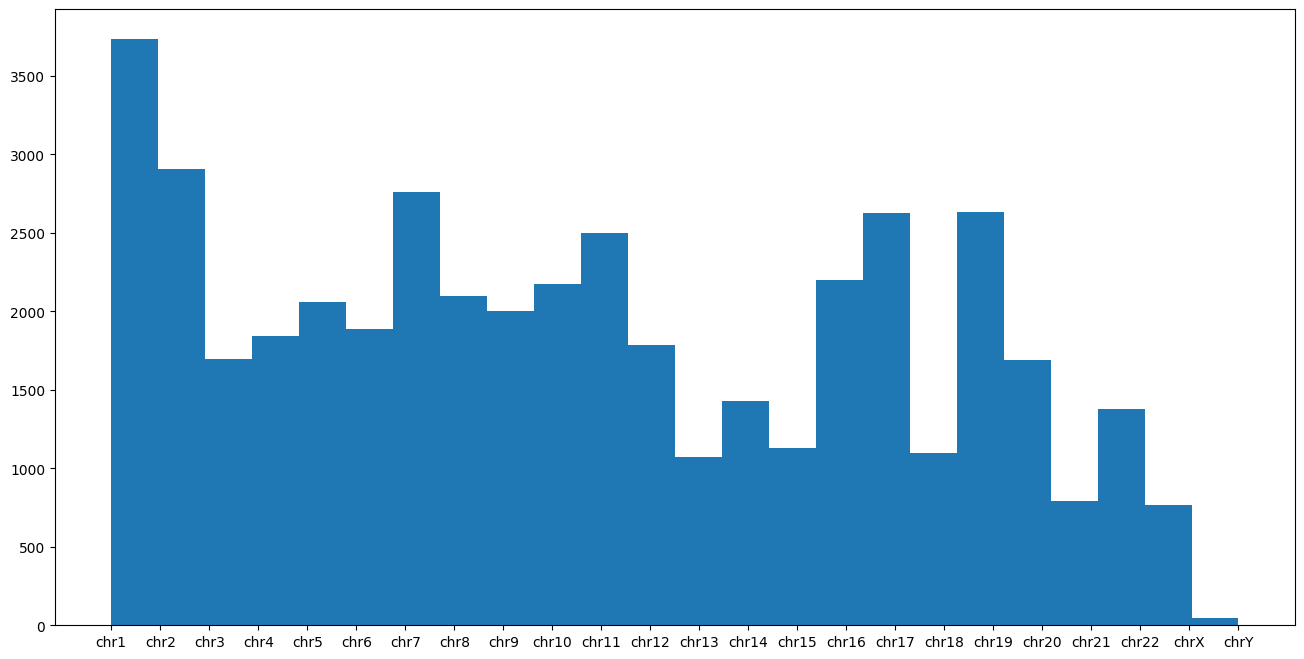

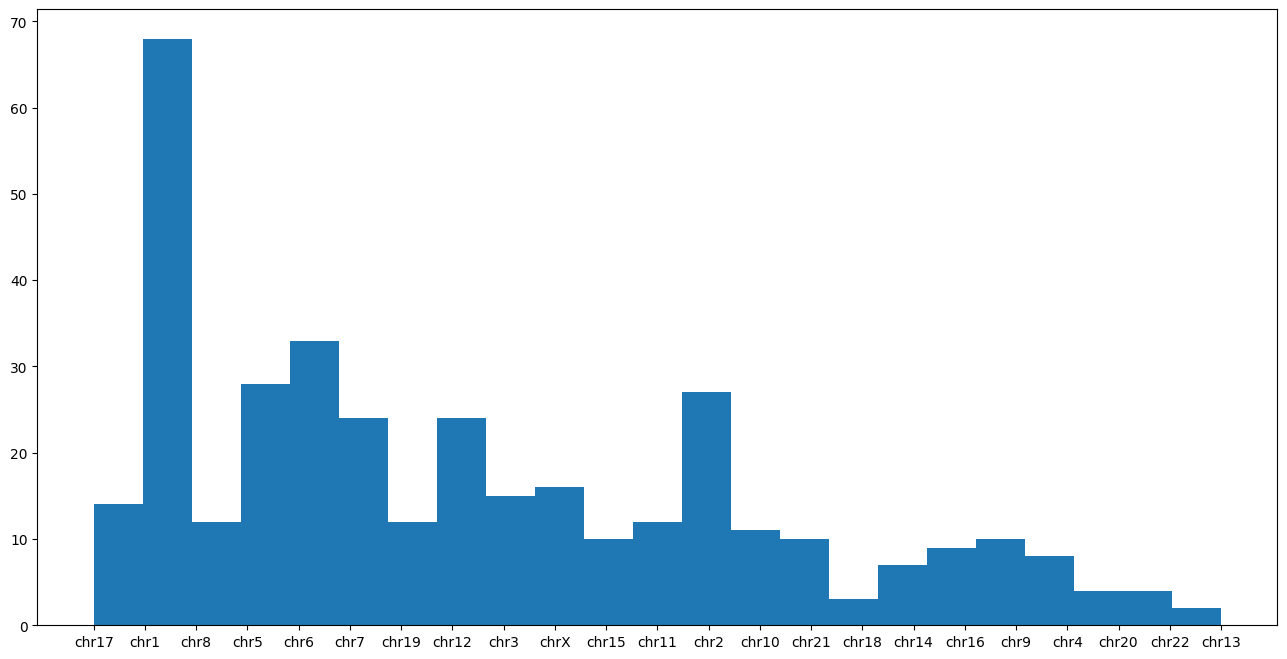

In [ ]:
data_preprocessor = DataPrep(beds_to_process, fastas_to_process)
data_preprocessor.process_all_files()

In [ ]:
bedWK_df = pd.read_csv('/content/WuKou16_filter_norm_to_512.bed', sep='\t', comment='t', header=None)
bed16_df = pd.read_csv('/content/zdna2016_filter_norm_to_512.bed', sep='\t', comment='t', header=None)
bedG_df = pd.read_csv('/content/G4_Chip_seq_filter_norm_to_500.bed', sep='\t', comment='t', header=None)
# bedH_df = pd.read_csv('/content/drive/My Drive/data_for_gans/H-DNA.bed', sep='\t', comment='t', header=None)

In [ ]:
un_bed_dataset = pd.concat([bedWK_df, bed16_df]).reset_index(drop=True)
un_bed_dataset = pd.concat([un_bed_dataset, bedG_df]).reset_index(drop=True)
# un_bed_dataset = pd.concat([un_bed_dataset, bedH_df]).reset_index(drop=True)

In [ ]:
un_bed_dataset

,0,1,2
0,chr1,845296,845808
1,chr1,845379,845891
2,chr1,845802,846314
3,chr1,845896,846408
4,chr1,848188,848700
...,...,...,...
53379,chrX,154255151,154255663
53380,chrX,154299323,154299835
53381,chrY,10033277,10033789
53382,chrY,10037570,10038082


In [ ]:
un_bed_dataset[:43936]

,0,1,2
0,chr1,845296,845808
1,chr1,845379,845891
2,chr1,845802,846314
3,chr1,845896,846408
4,chr1,848188,848700
...,...,...,...
43931,chrX,153166892,153167404
43932,chrY,234047,234559
43933,chrY,234181,234693
43934,chrY,234300,234812


In [ ]:
un_bed_dataset.columns = ['chrom', 'chromStart', 'chromEnd']

In [ ]:
# fasta_file_path = '/content/generated_sequences_zdna_gans.fasta'
# with open(fasta_file_path, 'r') as fasta_file:
#     fasta_lines = fasta_file.readlines()

# for i, line in enumerate(fasta_lines):
#     if line.startswith('> seq'):
#         chrom_index = i % len(un_bed_dataset[:43936].chrom)
#         chromosome_name = un_bed_dataset.chrom[chrom_index]
#         fasta_lines[i] = f'> {chromosome_name}\n'

# updated_fasta_file_path = 'updated_sequences.fasta'
# with open(updated_fasta_file_path, 'w') as updated_fasta_file:
#     updated_fasta_file.writelines(fasta_lines)

# CL

In [ ]:
sequences = []
ss_type = []
chromosomes = []
fasta_files = [
    '/content/WuKou2016_filter-norm_to_512.fasta',
    '/content/zdna2016_filter-norm_to_512.fasta'
]
for fasta_file in fasta_files:
  for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append(str(record.seq).upper())
    sequence = str(record.seq).upper()
    chrom_info = record.id.split('_')[0]
    chromosome = chrom_info if chrom_info.startswith("chr") else "chr" + chrom_info
    chromosomes.append(chromosome)

for seq in sequences:
    ss_type.append(types[0])
raw_dataset = pd.DataFrame({"chromosome": chromosomes, "raw_sequence": sequences, "type": ss_type, "label": 0})
raw_dataset.head()

,chromosome,raw_sequence,type,label
0,chr1:845296-845808,GCTATCTTCCAGGCCGGGAGGAAGGACCGAGGGTGGGCCCGGCGCG...,Z-DNA,0
1,chr1:845379-845891,CTGGTCCTGGCGCTGGGACCCGCAGCTGCGCCCTCTGCCTGAGCAG...,Z-DNA,0
2,chr1:845802-846314,CAGTCACCGGGGGCGGGGAGACTGGTCGACCACCCCTGAGGGCCCG...,Z-DNA,0
3,chr1:845896-846408,TCCTGGTTGAGCAGCTAGGGGGGTGTCTGGTAACCAGCCGGGCCCC...,Z-DNA,0
4,chr1:848188-848700,GCACTCCACAGCAGGAAGAAGGGCAGTGTGAACTGCTCACCACTGT...,Z-DNA,0


In [ ]:
sequences = []
ss_type = []
chromosomes = []
fasta_files = [
    '/content/G4_Chip_seq_quadruplex_norm_to_500.fa'
]
for fasta_file in fasta_files:
  for record in SeqIO.parse(fasta_file, "fasta"):
    sequences.append(str(record.seq).upper())
    sequence = str(record.seq).upper()
    chrom_info = record.id.split('_')[0]
    chromosome = chrom_info if chrom_info.startswith("chr") else "chr" + chrom_info
    chromosomes.append(chromosome)

for seq in sequences:
    ss_type.append(types[1])
g_dataset = pd.DataFrame({"chromosome": chromosomes, "raw_sequence": sequences, "type": ss_type, "label": 0})
g_dataset.head()

,chromosome,raw_sequence,type,label
0,chr1:713888-714400,CCCTTCTTCAGCCGGCAACACACAGAACCTGGCGGGGAGGTCACTC...,G-quad,0
1,chr1:762660-763172,GACGGAACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCT...,G-quad,0
2,chr1:839885-840397,CTCCGAACGTGGCCTCCTCCGAACGCGGCCGCCTCCTCCTCCGAAC...,G-quad,0
3,chr1:894460-894972,CCTGCGGGTCACGCAGGAGTCACAGCTGCCCGCACGCCCAGCTCGC...,G-quad,0
4,chr1:935301-935813,GCGCTCCTGCCATCGGCGAGGCGCTCGGTTTCCCCGGCGTGTCTGC...,G-quad,0


In [ ]:
print(raw_dataset.shape)
print(g_dataset.shape)
# print(h_dataset.shape)

(44661, 4)
(8723, 4)


In [ ]:
raw_dataset = pd.concat([raw_dataset, g_dataset]).sample(frac=1).reset_index(drop=True)

In [ ]:
raw_dataset = pd.concat([raw_dataset, h_dataset]).sample(frac=1).reset_index(drop=True)

NameError: name 'h_dataset' is not defined

In [ ]:
raw_dataset = g_dataset

In [ ]:
raw_dataset.shape

(8723, 4)

In [ ]:
val_chromosomes = ['chr3', 'chr8', 'chr15', 'chr17', 'chr20', 'chrX']

raw_dataset['short_chrom'] = raw_dataset['chromosome'].apply(lambda x: x.split(':')[0])

val_set = raw_dataset[raw_dataset['short_chrom'].isin(val_chromosomes)]
train_set = raw_dataset[~raw_dataset['short_chrom'].isin(val_chromosomes)]

val_set = val_set.drop(columns=['short_chrom'])
train_set = train_set.drop(columns=['short_chrom'])

In [ ]:
raw_dataset.to_csv("/content/drive/My Drive/New_Full_data.csv", index=False)

In [ ]:
raw_dataset.raw_sequence

,raw_sequence
0,CCCTTCTTCAGCCGGCAACACACAGAACCTGGCGGGGAGGTCACTC...
1,GACGGAACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCT...
2,CTCCGAACGTGGCCTCCTCCGAACGCGGCCGCCTCCTCCTCCGAAC...
3,CCTGCGGGTCACGCAGGAGTCACAGCTGCCCGCACGCCCAGCTCGC...
4,GCGCTCCTGCCATCGGCGAGGCGCTCGGTTTCCCCGGCGTGTCTGC...
...,...
8718,TTGCGGAGACTGCAAGCAGCCGCGGCGCGCCCGGCCCTCCCTCTTC...
8719,CGCACGGGTCTCCTTAGCGGGCGGGCAAAATGGGCGCCGGTACTCG...
8720,CAGACTGCGACGGCTCAAGGTTCCCACACGCAGAATTTTCCTGGTA...
8721,TGGTGTCAGCATTTGTCCCTCCCACCCCCATGGACGGCACCACCTC...


In [ ]:
raw_dataset.type

,type
0,G-quad
1,G-quad
2,G-quad
3,G-quad
4,G-quad
...,...
8718,G-quad
8719,G-quad
8720,G-quad
8721,G-quad


# DF

In [ ]:
raw_dataset = pd.read_csv("/content/drive/My Drive/Zdna.csv")

In [ ]:
raw_dataset.head()

,chromosome,raw_sequence,type,label,short_chrom
0,chr1:713888-714400,CCCTTCTTCAGCCGGCAACACACAGAACCTGGCGGGGAGGTCACTC...,G-quad,0,chr1
1,chr1:762660-763172,GACGGAACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCT...,G-quad,0,chr1
2,chr1:839885-840397,CTCCGAACGTGGCCTCCTCCGAACGCGGCCGCCTCCTCCTCCGAAC...,G-quad,0,chr1
3,chr1:894460-894972,CCTGCGGGTCACGCAGGAGTCACAGCTGCCCGCACGCCCAGCTCGC...,G-quad,0,chr1
4,chr1:935301-935813,GCGCTCCTGCCATCGGCGAGGCGCTCGGTTTCCCCGGCGTGTCTGC...,G-quad,0,chr1


Scale data from $[0;1]$ to $[-1, 1] → $BitDiffusion

In [ ]:
X_train = np.array(
    [one_hot_encode(x, NUCLEOTIDES, 512) for x in tqdm_notebook(train_set.raw_sequence) if 'N' not in x]
)
X_train = np.array([x.T.tolist() for x in X_train])
X_train[X_train == 0] = -1
X_val = np.array(
    [one_hot_encode(x, NUCLEOTIDES, 512) for x in tqdm_notebook(val_set.raw_sequence) if 'N' not in x]
)
X_val = np.array([x.T.tolist() for x in X_val])
X_val[X_val == 0] = -1

<ipython-input-39-2457d02acc97>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  [one_hot_encode(x, NUCLEOTIDES, 512) for x in tqdm_notebook(train_set.raw_sequence) if 'N' not in x]


  0%|          | 0/6797 [00:00<?, ?it/s]

<ipython-input-39-2457d02acc97>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  [one_hot_encode(x, NUCLEOTIDES, 512) for x in tqdm_notebook(val_set.raw_sequence) if 'N' not in x]


  0%|          | 0/1926 [00:00<?, ?it/s]

In [ ]:
# def preprocess_sequences(data, max_length, nucleotides):
#     processed_data = []
#     for x in data:
#         if 'N' not in x:
#             processed_data.append(one_hot_encode(x, nucleotides, max_length))
#     processed_data = np.array([x.T.tolist() for x in processed_data])
#     processed_data[processed_data == 0] = -1
#     return processed_data

# def generate_batches(data, batch_size):
#     for i in range(0, len(data), batch_size):
#         yield data[i:i+batch_size]

In [ ]:
# batch_size = 1000
# max_length = 512

In [ ]:
# X_train = np.concatenate([
#     preprocess_sequences(batch, max_length, NUCLEOTIDES)
#     for batch in generate_batches(train_set.raw_sequence, batch_size)
# ])


In [ ]:
# X_val = np.concatenate([
#     preprocess_sequences(batch, max_length, NUCLEOTIDES)
#     for batch in generate_batches(val_set.raw_sequence, batch_size)
# ])

In [ ]:
y_X_train = torch.from_numpy(train_set["label"].to_numpy())
y_X_val = torch.from_numpy(val_set["label"].to_numpy())

In [ ]:
tf = T.Compose([T.ToTensor()])
seq_dataset_train = SequenceDataset(seqs=X_train, c=y_X_train, transform=tf)
train_dl = DataLoader(seq_dataset_train, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
seq_dataset_val = SequenceDataset(seqs=X_val, c=y_X_val, transform=tf)
val_dl = DataLoader(seq_dataset_val, BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

# KAN

In [ ]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output

        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=True):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

Kan conv

In [ ]:
#Util
def add_padding_1d(array: np.ndarray, padding: int) -> np.ndarray:
    """Adds padding to a 1D array."""
    n = array.shape[0]
    padded_array = np.zeros(n + 2 * padding)
    padded_array[padding: n + padding] = array
    return padded_array


def calc_out_dims_1d(array, kernel_size, stride, dilation, padding):
    """Calculate output dimensions for 1D convolution."""
    batch_size, n_channels, n = matrix.shape
    out_size = np.floor((n + 2 * padding - kernel_size - (kernel_size - 1) * (dilation - 1)) / stride).astype(int) + 1
    return out_size, batch_size, n_channels


def multiple_convs_kan_conv1d(array,
                               kernels,
                               kernel_size,
                               out_channels,
                               stride=1,
                               dilation=1,
                               padding=0,
                               device="cuda") -> torch.Tensor:
    """Performs a 1D convolution with multiple kernels on the input array using specified stride, dilation, and padding.

    Args:
        array (torch.Tensor): 1D tensor of shape (batch_size, channels, length).
        kernels (list): List of kernel functions to be applied.
        kernel_size (int): Size of the 1D kernel.
        out_channels (int): Number of output channels.
        stride (int): Stride along the length of the array. Default is 1.
        dilation (int): Dilation rate along the length of the array. Default is 1.
        padding (int): Number of elements to pad on each side. Default is 0.
        device (str): Device to perform calculations on. Default is "cuda".

    Returns:
        torch.Tensor: Feature map after convolution with shape (batch_size, out_channels, length_out).
    """
    length_out, batch_size = calc_out_dims_1d(array, kernel_size, stride, dilation, padding)
    n_convs = len(kernels)

    array_out = torch.zeros((batch_size, out_channels, length_out)).to(device)

    array = F.pad(array, (padding, padding), mode='constant', value=0)
    conv_groups = array.unfold(2, kernel_size, stride)
    conv_groups = conv_groups.contiguous()

    kern_per_out = len(kernels) // out_channels

    for c_out in range(out_channels):
        out_channel_accum = torch.zeros((batch_size, length_out), device=device)

        for k_idx in range(kern_per_out):
            kernel = kernels[c_out * kern_per_out + k_idx]
            conv_result = kernel(conv_groups.view(-1, 1, kernel_size))
            out_channel_accum += conv_result.view(batch_size, length_out)

        array_out[:, c_out, :] = out_channel_accum

    return array_out

In [ ]:
def kan_conv1d(matrix: torch.Tensor,
               kernel,
               kernel_size: int,
               stride: int = 1,
               dilation: int = 1,
               padding: int = 0,
               device: str = "cpu") -> torch.Tensor:
    """
    Performs a 1D convolution with the given kernel over a 1D matrix using the defined stride, dilation, and padding.

    Args:
        matrix (torch.Tensor): 3D tensor (batch_size, channels, width) to be convolved.
        kernel (function): Kernel function to apply on the 1D patches of the matrix.
        kernel_size (int): Size of the kernel (assumed to be square).
        stride (int, optional): Stride along the width axis. Defaults to 1.
        dilation (int, optional): Dilation along the width axis. Defaults to 1.
        padding (int, optional): Padding along the width axis. Defaults to 0.
        device (str): Device to perform the operation on (e.g., "cuda" or "cpu").

    Returns:
        torch.Tensor: 1D Feature map after convolution.
    """

    batch_size, n_channels, width_in = matrix.shape
    width_out = ((width_in + 2 * padding - dilation * (kernel_size - 1) - 1) // stride) + 1
    matrix_out = torch.zeros((batch_size, n_channels, width_out), device=device)

    matrix_padded = torch.nn.functional.pad(matrix, (padding, padding))

    for i in range(width_out):

        start = i * stride
        end = start + kernel_size * dilation
        patch = matrix_padded[:, :, start:end:dilation]

        matrix_out[:, :, i] = kernel.forward(patch).squeeze(-1)

    return matrix_out

In [ ]:
class KAN_Convolutional_Layer_1D(torch.nn.Module):
    def __init__(self, in_channels=1, out_channels=1, kernel_size=5, stride=1, padding=0, dilation=1, device="cuda"):
        super(KAN_Convolutional_Layer_1D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.device = device
        self.convs = torch.nn.ModuleList([KAN_Convolution_1D(kernel_size, stride, padding, dilation, device) for _ in range(in_channels * out_channels)])

    def forward(self, x: torch.Tensor):
        return torch.cat([conv(x[:, i, :].unsqueeze(1)) for i, conv in enumerate(self.convs)], dim=1)

In [ ]:
class KAN_Convolutional_Layer_1D(torch.nn.Module):
    def __init__(
            self,
            in_channels: int = 1,
            out_channels: int = 1,
            kernel_size: int = 2,
            stride: int = 1,
            padding: int = 0,
            dilation: int = 1,
            grid_size: int = 5,
            spline_order: int = 3,
            scale_noise: float = 0.1,
            scale_base: float = 1.0,
            scale_spline: float = 1.0,
            base_activation=torch.nn.SiLU,
            grid_eps: float = 0.02,
            grid_range: tuple = [-1, 1],
            device: str = "cpu"
        ):
        super(KAN_Convolutional_Layer_1D, self).__init__()
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.padding = padding
        self.stride = stride


        self.convs = torch.nn.ModuleList()
        for _ in range(in_channels * out_channels):
            self.convs.append(
                KAN_Convolution_1D(
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                    dilation=dilation,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor):
        batch_size, in_channels, length = x.shape
        output_length = (length + 2 * self.padding - self.dilation * (self.kernel_size - 1) - 1) // self.stride + 1
        output = torch.zeros((batch_size, self.out_channels, output_length), device=x.device)


        for i in range(self.out_channels):
            output_accum = torch.zeros((batch_size, output_length), device=x.device)
            for j in range(self.in_channels):
                kernel_idx = i * self.in_channels + j
                conv_result = self.convs[kernel_idx].forward(x[:, j, :].unsqueeze(1))
                output_accum += conv_result.squeeze(1)  # Squeeze
            output[:, i, :] = output_accum  # A to output channel

        return output

class KAN_Convolution_1D(torch.nn.Module):
    def __init__(
            self,
            kernel_size: int = 2,
            stride: int = 1,
            padding: int = 0,
            dilation: int = 1,
            grid_size: int = 50,
            spline_order: int = 3,
            scale_noise: float = 0.1,
            scale_base: float = 1.0,
            scale_spline: float = 1.0,
            base_activation=torch.nn.SiLU,
            grid_eps: float = 0.02,
            grid_range: tuple = [-1, 1]
        ):
        super(KAN_Convolution_1D, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.conv = KANLinear(
            in_features = kernel_size,
            out_features = 1,
            grid_size=grid_size,
            spline_order=spline_order,
            scale_noise=scale_noise,
            scale_base=scale_base,
            scale_spline=scale_spline,
            base_activation=base_activation,
            grid_eps=grid_eps,
            grid_range=grid_range
        )

    def forward(self, x: torch.Tensor):
        self.device = x.device
        return kan_conv1d(x, self.conv, self.kernel_size,self.stride, self.dilation, self.padding, self.device)

# Forward Diffusion

In [ ]:
# Scheduler


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)


def linear_beta_schedule(timesteps, beta_end=0.005):
    beta_start = 0.0001

    return torch.linspace(beta_start, beta_end, timesteps)


def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2


def sigmoid_beta_schedule(timesteps):
    beta_start = 0.001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start


# define beta schedule
betas = linear_beta_schedule(timesteps=TIMESTEPS, beta_end=0.2)
# define alphas
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
# sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


# Conditioned (improved) sampling


@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    # print (x.shape, 'x_shape')
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, time=t) / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


# Sampling based on Denoising Diffusion Implicit Models (https://arxiv.org/abs/2010.02502)

@torch.no_grad()
def p_ddpm_sample(model, x, t, t_index, eta=0, temp=1.0):
    alpha_t = extract(alphas_cumprod, t, x.shape)
    alpha_prev_t = extract(alphas_cumprod_prev, t, x.shape)
    sigma = eta * ((1 - alpha_prev_t) / (1 - alpha_t) * (1 - alpha_t / alpha_prev_t)) ** 0.5
    sqrt_one_minus_alphas_cumprod = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    pred_x0 = (x - sqrt_one_minus_alphas_cumprod * model(x, time=t)) / (alpha_t**0.5)
    dir_xt = (1.0 - alpha_prev_t - sigma**2).sqrt() * model(x, time=t)
    if sigma == 0.0:
        noise = 0.0
    else:
        noise = torch.randn((1, x.shape[1:]))
    noise *= temp

    x_prev = (alpha_prev_t**0.5) * pred_x0 + dir_xt + sigma * noise

    return x_prev


@torch.no_grad()
def p_ddim_sample(model, x, t, t_index, eta=0, temp=1.0):
    alpha_t = extract(alphas_cumprod, t, x.shape)
    alpha_prev_t = extract(alphas_cumprod_prev, t, x.shape)
    sigma = eta * ((1 - alpha_prev_t) / (1 - alpha_t) * (1 - alpha_t / alpha_prev_t)) ** 0.5
    sqrt_one_minus_alphas_cumprod = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    pred_x0 = (x - sqrt_one_minus_alphas_cumprod * model(x, time=t)) / (alpha_t**0.5)
    dir_xt = (1.0 - alpha_prev_t - sigma**2).sqrt() * model(x, time=t)
    if sigma == 0.0:
        noise = 0.0
    else:
        noise = torch.randn((1, x.shape[1:]))
    noise *= temp

    x_prev = (alpha_prev_t**0.5) * pred_x0 + dir_xt + sigma * noise

    return x_prev


@torch.no_grad()
def p_sample_guided(model, x, classes, t, t_index, context_mask, cond_weight=0.0):
    # adapted from: https://openreview.net/pdf?id=qw8AKxfYbI
    # print (classes[0])
    batch_size = x.shape[0]
    # double to do guidance with
    t_double = t.repeat(2)
    x_double = x.repeat(2, 1, 1, 1)
    betas_t = extract(betas, t_double, x_double.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t_double, x_double.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t_double, x_double.shape)

    # classifier free sampling interpolates between guided and non guided using `cond_weight`
    classes_masked = classes * context_mask
    classes_masked = classes_masked.type(torch.long)
    # print ('class masked', classes_masked)
    preds = model(x_double, time=t_double, classes=classes_masked)
    eps1 = (1 + cond_weight) * preds[:batch_size]
    eps2 = cond_weight * preds[batch_size:]
    x_t = eps1 - eps2

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t[:batch_size] * (
        x - betas_t[:batch_size] * x_t / sqrt_one_minus_alphas_cumprod_t[:batch_size]
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise


# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, classes, shape, cond_weight):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    if classes is not None:
        n_sample = classes.shape[0]
        context_mask = torch.ones_like(classes).to(device)
        # make 0 index unconditional
        # double the batch
        classes = classes.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 0.0  # makes second half of batch context free
        sampling_fn = partial(p_sample_guided, classes=classes, cond_weight=cond_weight, context_mask=context_mask)
    else:
        sampling_fn = partial(p_sample)

    for i in tqdm(reversed(range(0, TIMESTEPS)), desc='sampling loop time step', total=TIMESTEPS):
        img = sampling_fn(model, x=img, t=torch.full((b,), i, device=device, dtype=torch.long), t_index=i)
        imgs.append(img.cpu().numpy())
    return imgs


@torch.no_grad()
def sample(model, image_size, classes=None, batch_size=16, channels=3, cond_weight=0):
    return p_sample_loop(model, classes=classes, shape=(batch_size, channels, 4, image_size), cond_weight=cond_weight)

### Loss function

In [ ]:
def q_sample(x_start, t, noise=None):
    """
    Forward pass with noise.
    """
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


def p_losses(denoise_model, x_start, t, classes, noise=None, loss_type="l1", p_uncond=0.1):
    """
    Calculate the loss conditioned and noise injected.
    """
    device = x_start.device
    if noise is None:
        noise = torch.randn_like(x_start)  #  gauss noise
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)  # this is the auto generated noise given t and Noise

    context_mask = torch.bernoulli(torch.zeros(classes.shape[0]) + (1 - p_uncond)).to(device)

    # mask for unconditinal guidance
    classes = classes * context_mask
    classes = classes.type(torch.long)
    predicted_noise = denoise_model(x_noisy, t, classes)
    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [ ]:
def p_losses_dist(teacher_model, student_model, x_start, t, classes, noise=None, loss_type="huber", p_uncond=0.1, alpha=1e-2):
    """
    Calculate the loss conditioned and noise injected.
    """
    teacher_model.eval()
    device = x_start.device
    if noise is None:
        noise = torch.randn_like(x_start)  #  gauss noise
        context_mask_t = torch.bernoulli(torch.zeros(classes.shape[0]) + (1 - p_uncond)).to(device)
        classes_t = classes * context_mask_t
        classes_t = classes_t.type(torch.long)
        teacher_noise = teacher_model(x_start, t, classes_t)
    x_noisy = q_sample(x_start=x_start, t=t, noise=teacher_noise)  # this is the auto generated noise given t and Noise

    context_mask = torch.bernoulli(torch.zeros(classes.shape[0]) + (1 - p_uncond)).to(device)

    # mask for unconditinal guidance
    classes = classes * context_mask
    classes = classes.type(torch.long)
    predicted_noise = student_model(x_noisy, t, classes)

    loss = F.smooth_l1_loss(teacher_noise, predicted_noise)


    return loss

# Unet denoiser

In [ ]:
# Building blocks of UNET

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'), nn.Conv2d(dim, default(dim_out, dim), 3, padding=1)
    )


def Downsample(dim, dim_out=None):
    return nn.Conv2d(dim, default(dim_out, dim), 4, 2, 1)


class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim=1, unbiased=False, keepdim=True)
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) * (var + eps).rsqrt() * self.g


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


# Building blocks of UNET, positional embeds


class LearnedSinusoidalPosEmb(nn.Module):

    """ https://github.com/crowsonkb/v-diffusion-jax/blob/master/diffusion/models/danbooru_128.py#L8 """

    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim=-1)
        fouriered = torch.cat((x, fouriered), dim=-1)
        return fouriered


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things
        '''
        self.input_dim = input_dim
        # layers = [nn.Linear(input_dim, emb_dim), nn.GELU(), nn.Linear(emb_dim, emb_dim)]
        layers = [KANLinear(input_dim, emb_dim),  KANLinear(emb_dim, emb_dim)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


# Building blocks of UNET, building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


# Building blocks of UNET, residual part


class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        # self.mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2)) if exists(time_emb_dim) else None
        self.mlp = nn.Sequential(nn.SiLU(), KANLinear(time_emb_dim, dim_out * 2)) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)


# Additional code to the https://github.com/lucidrains/bit-diffusion/blob/main/bit_diffusion/bit_diffusion.py


class ResnetBlockClassConditioned(ResnetBlock):
    def __init__(self, dim, dim_out, *, num_classes, class_embed_dim, time_emb_dim=None, groups=8):
        super().__init__(dim=dim + class_embed_dim, dim_out=dim_out, time_emb_dim=time_emb_dim, groups=groups)
        # self.class_mlp = EmbedFC(num_classes, class_embed_dim)
        self.class_mlp = EmbedFC(num_classes, class_embed_dim)

    def forward(self, x, time_emb=None, c=None):
        emb_c = self.class_mlp(c)
        emb_c = emb_c.view(*emb_c.shape, 1, 1)
        emb_c = emb_c.expand(-1, -1, x.shape[-2], x.shape[-1])
        x = torch.cat([x, emb_c], axis=1)

        return super().forward(x, time_emb)


# Building blocks of UNET, attention part


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), LayerNorm(dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads), qkv)

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        v = v / (h * w)

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h=self.heads, x=h, y=w)
        return self.to_out(out)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32, scale=10):
        super().__init__()
        self.scale = scale
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads), qkv)

        q, k = map(l2norm, (q, k))

        sim = einsum('b h d i, b h d j -> b h i j', q, k) * self.scale
        attn = sim.softmax(dim=-1)
        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x=h, y=w)
        return self.to_out(out)


# Core part of UNET


class Unet(nn.Module):
    """
    Refer to the main paper for the architecture details https://arxiv.org/pdf/2208.04202.pdf
    """

    def __init__(
        self,
        dim,
        init_dim=100,
        dim_mults=(1, 2, 4),
        channels=CHANNELS,
        resnet_block_groups=8,
        learned_sinusoidal_dim=18,
        num_classes=10,
        class_embed_dim=3,
    ):
        super().__init__()

        self.channels = channels
        # if you want to do self conditioning uncomment this
        # input_channels = channels * 2
        input_channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, (7, 7), padding=3)
        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        time_dim = dim * 4

        sinu_pos_emb = LearnedSinusoidalPosEmb(learned_sinusoidal_dim)
        fourier_dim = learned_sinusoidal_dim + 1

        self.time_mlp = nn.Sequential(
            sinu_pos_emb, nn.Linear(fourier_dim, time_dim), nn.GELU(), nn.Linear(time_dim, time_dim)
        )

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in) if not is_last else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, 1, 1)
        print('final', dim, channels, self.final_conv)

    # Additional code to the https://github.com/lucidrains/bit-diffusion/blob/main/bit_diffusion/bit_diffusion.py mostly in forward method.

    def forward(self, x, time, classes, x_self_cond=None):
        x = self.init_conv(x)
        r = x.clone()

        t_start = self.time_mlp(time)
        t_mid = t_start.clone()
        t_end = t_start.clone()

        if classes is not None:
            t_start += self.label_emb(classes)
            t_mid += self.label_emb(classes)
            t_end += self.label_emb(classes)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t_start)
            h.append(x)

            x = block2(x, t_start)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t_mid)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t_mid)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t_mid)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t_mid)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)
        x = self.final_res_block(x, t_end)

        x = self.final_conv(x)
        return x

# Reverse

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model = Unet(
    dim=100,
    channels=CHANNELS,
    dim_mults=(1, 2, 4),
    resnet_block_groups=RESNET_BLOCK_GROUPS,
    num_classes=TOTAL_CLASS_NUMBER,
)
accelerator = Accelerator(gradient_accumulation_steps=gradient_accumulation_steps)
model.to(device)

final 100 1 Conv2d(100, 1, kernel_size=(1, 1), stride=(1, 1))


Unet(
  (init_conv): Conv2d(1, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): LearnedSinusoidalPosEmb()
    (1): Linear(in_features=19, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
  )
  (label_emb): Embedding(2, 400)
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): KANLinear(
            (base_activation): SiLU()
          )
        )
        (block1): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )


Number of params is flexed by IMAGE_SIZE parameter

In [ ]:
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  46347610


In [ ]:
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.99, 0.99))

In [ ]:
TIMESTEPS = 100

  0%|          | 0/90 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

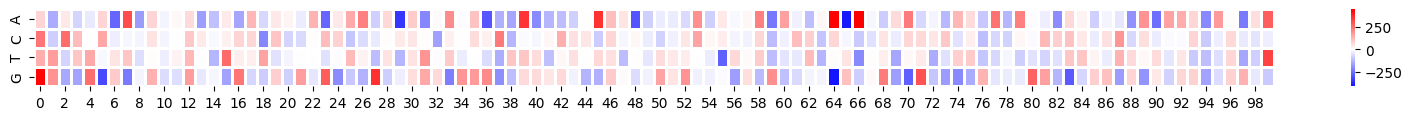

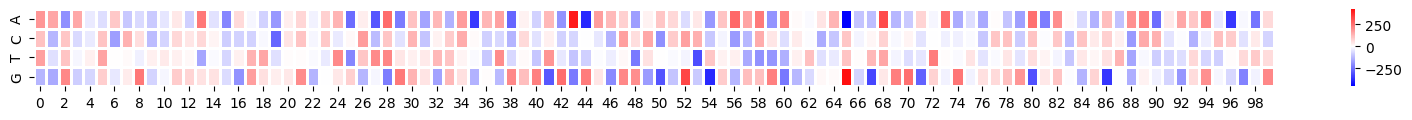

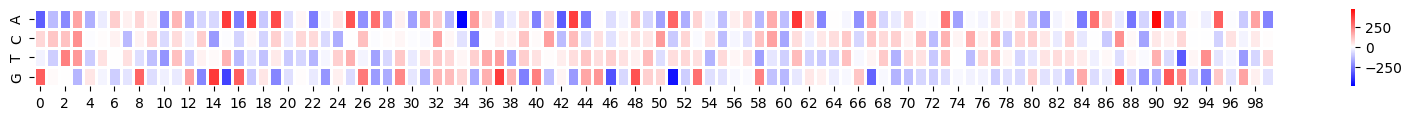

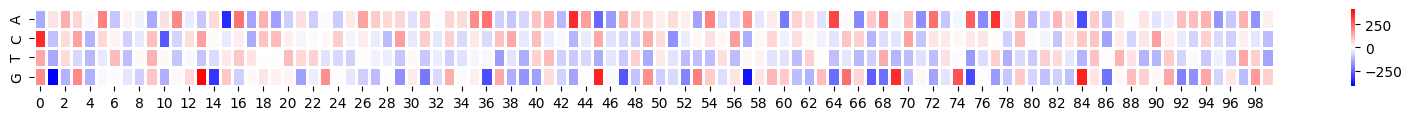

 Epoch 0 Train Loss: 0.17162156105041504 | Val Loss: 0.17449715025415105
 Epoch 1 Train Loss: 0.13403689861297607 | Val Loss: 0.12340795876812344
 Epoch 2 Train Loss: 0.0919107124209404 | Val Loss: 0.10880513375332533
 Epoch 3 Train Loss: 0.0758717805147171 | Val Loss: 0.10344583551160806
 Epoch 4 Train Loss: 0.10106255114078522 | Val Loss: 0.10018951704433142
 Epoch 5 Train Loss: 0.07195883989334106 | Val Loss: 0.09532276374742019
 Epoch 6 Train Loss: 0.07018668204545975 | Val Loss: 0.08791519482889451
 Epoch 7 Train Loss: 0.06920509040355682 | Val Loss: 0.08573354555925061
 Epoch 8 Train Loss: 0.0964282676577568 | Val Loss: 0.08094527089029305
 Epoch 9 Train Loss: 0.07604079693555832 | Val Loss: 0.07998009831913985
 Epoch 10 Train Loss: 0.06455949693918228 | Val Loss: 0.07480785355341336
 Epoch 11 Train Loss: 0.07116124778985977 | Val Loss: 0.07098884812810204
 Epoch 12 Train Loss: 0.11972562968730927 | Val Loss: 0.07008697583594105
 Epoch 13 Train Loss: 0.0671742707490921 | Val Loss

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

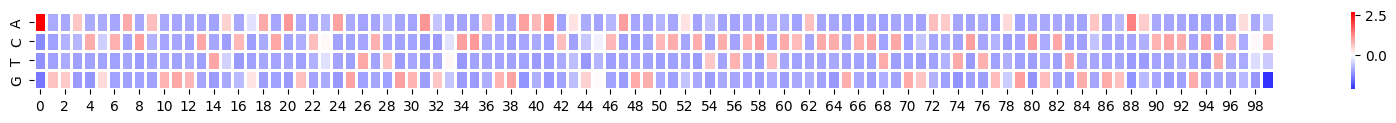

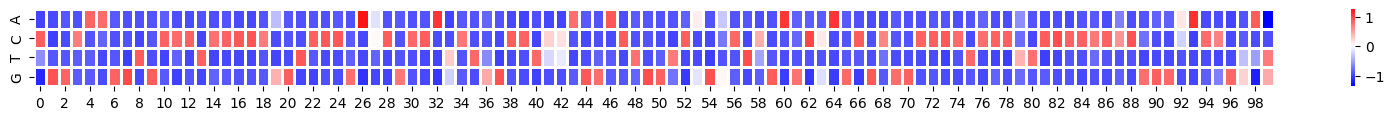

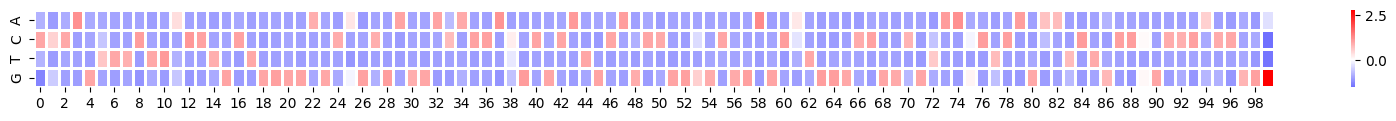

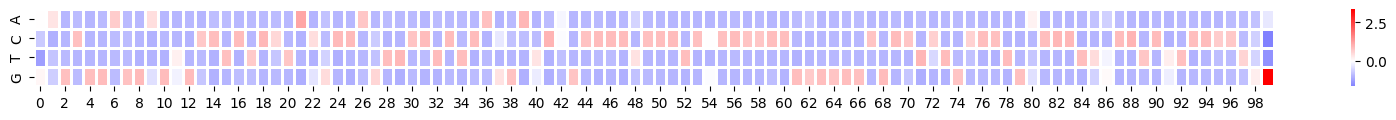

 Epoch 30 Train Loss: 0.0665956437587738 | Val Loss: 0.04487431717436176
 Epoch 31 Train Loss: 0.020316490903496742 | Val Loss: 0.043230022857935466
 Epoch 32 Train Loss: 0.03577641770243645 | Val Loss: 0.04336294402514607
 Epoch 33 Train Loss: 0.05274736508727074 | Val Loss: 0.04378333484584635
 Epoch 34 Train Loss: 0.036720532923936844 | Val Loss: 0.043682431201796885
 Epoch 35 Train Loss: 0.01915050484240055 | Val Loss: 0.04032957998743235
 Epoch 36 Train Loss: 0.02307143062353134 | Val Loss: 0.04224736325073341
 Epoch 37 Train Loss: 0.032044798135757446 | Val Loss: 0.040965051397927534
 Epoch 38 Train Loss: 0.03756648302078247 | Val Loss: 0.04348197911119412
 Epoch 39 Train Loss: 0.030044004321098328 | Val Loss: 0.040858045805338
 Epoch 40 Train Loss: 0.024077409878373146 | Val Loss: 0.040366341929482526
 Epoch 41 Train Loss: 0.02572871372103691 | Val Loss: 0.040529952546165995
 Epoch 42 Train Loss: 0.021156052127480507 | Val Loss: 0.04090536354987089
 Epoch 43 Train Loss: 0.022252

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

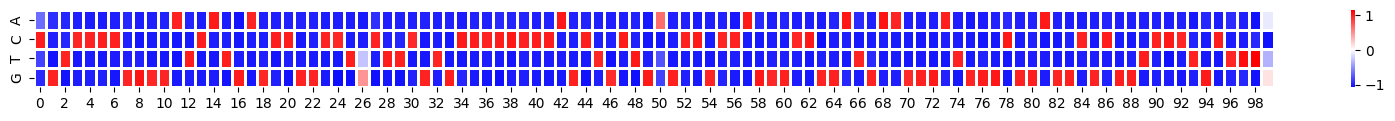

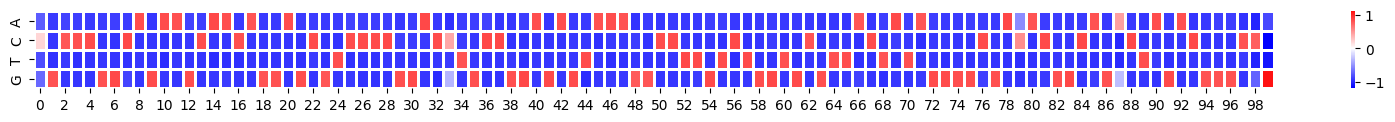

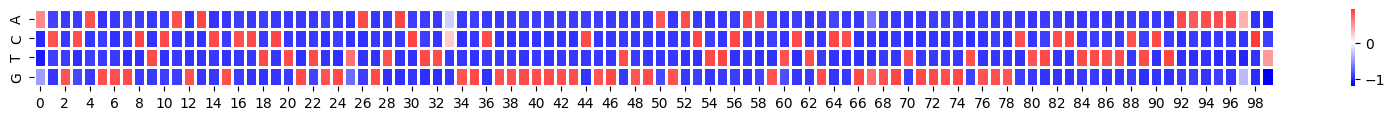

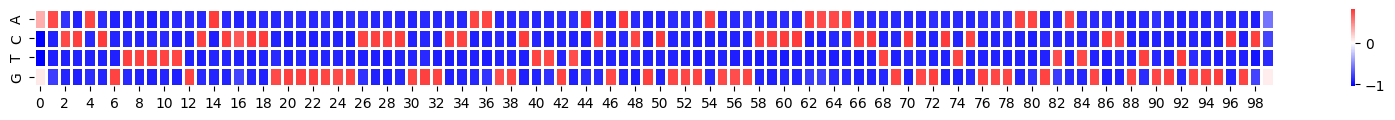

 Epoch 60 Train Loss: 0.057542119175195694 | Val Loss: 0.03635540325964285
 Epoch 61 Train Loss: 0.024126389995217323 | Val Loss: 0.042008538030026375
 Epoch 62 Train Loss: 0.02521745301783085 | Val Loss: 0.036098477130463304
 Epoch 63 Train Loss: 0.033675022423267365 | Val Loss: 0.03502616113097953
 Epoch 64 Train Loss: 0.04173080623149872 | Val Loss: 0.03778024164051556
 Epoch 65 Train Loss: 0.020472273230552673 | Val Loss: 0.03713447478222699
 Epoch 66 Train Loss: 0.03033674880862236 | Val Loss: 0.038373490595374225
 Epoch 67 Train Loss: 0.015863291919231415 | Val Loss: 0.03463087357919325
 Epoch 68 Train Loss: 0.026816293597221375 | Val Loss: 0.03849926958830396
 Epoch 69 Train Loss: 0.02624553069472313 | Val Loss: 0.03728736781569059
 Epoch 70 Train Loss: 0.04817397519946098 | Val Loss: 0.03455254364727942
 Epoch 71 Train Loss: 0.035931140184402466 | Val Loss: 0.03576524350946107
 Epoch 72 Train Loss: 0.029121994972229004 | Val Loss: 0.03622717426489454
 Epoch 73 Train Loss: 0.047

In [ ]:
model, optimizer, dataloader = accelerator.prepare(model, optimizer, train_dl)
ema = EMA(0.999)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)
train_loss_values = []
val_loss_values = []
num_train_batches = 0
for epoch in tqdm(range(90)):
    model.train()
    for step, train_batch in enumerate(dataloader):
        with accelerator.accumulate(model):
          x, y = train_batch
          x = x.type(torch.float32).to(device)
          y = y.type(torch.long).to(device)
          batch_size = x.shape[0]

          t = torch.randint(0, TIMESTEPS, (batch_size,), device=device).long()
          train_loss = p_losses(model, x, t, y, loss_type="huber")
          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()
          ema.step_ema(ema_model, model)
          num_train_batches += 1
          torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=0.2
        )

    # Validation loop
    model.eval()
    val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for val_batch in val_dl:
            val_x, val_y = val_batch
            val_x = val_x.type(torch.float32).to(device)
            val_y = val_y.type(torch.long).to(device)
            val_batch_size = val_x.shape[0]

            val_t = torch.randint(0, TIMESTEPS, (val_batch_size,), device=device).long()
            val_loss += p_losses(model, val_x, val_t, val_y, loss_type="huber").item()
            num_val_batches += 1
    val_loss /= num_val_batches
    if epoch % 30 == 0:
        sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, 16))
        random_classes = sampled.to(device)
        samples = sample(model, classes=random_classes, image_size=100, batch_size=16, channels=1, cond_weight=1)
        n_print = 0
        for image, class_show in zip(samples[-1], random_classes):
            if n_print < 4:
                plt.rcParams["figure.figsize"] = (20, 1)
                pd_seq = pd.DataFrame(image.reshape(4, 100))
                pd_seq.index = NUCLEOTIDES
                sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
                plt.show()
                plt.rcParams["figure.figsize"] = (2, 2)
                n_print = n_print + 1
    train_loss_values.append(train_loss.item())
    val_loss_values.append(val_loss)
    print(f" Epoch {epoch} Train Loss: {train_loss.item()} | Val Loss: {val_loss}")

# Plotting
# plt.plot(range(len(val_loss_values)), val_loss_values, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Validation Loss SP-MSE')
# plt.legend()
# plt.grid(True)

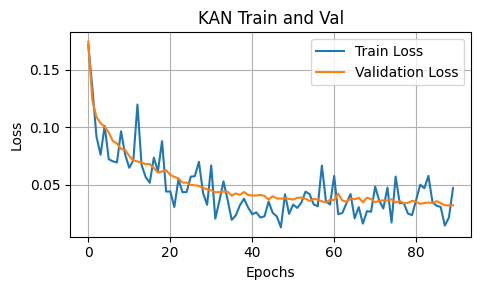

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('KAN Train and Val')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), 'diff_kan_100.pth')

In [ ]:
sampling_reverse_encoding(20)

  0%|          | 0/20 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
gen_seqs = []
fasta_files = [
    'kan_synthetic_seqs.fasta'
]
for fasta_file in fasta_files:
  for record in SeqIO.parse(fasta_file, "fasta"):
    gen_seqs.append(str(record.seq).upper())

generated_dataset = pd.DataFrame({"raw_sequence": gen_seqs})
generated_dataset.head()

,raw_sequence
0,ACCCAGGACTGGGCCTCCCTCTCTGACCTTACACCACAGTCATGCC...
1,ATCAGGGGGCGGGGGCATATCATCGGGGCGCCCGGCGTGCCGTCCC...
2,GGGGGCACGCGCAAAGGCAGGGGACCCTCCTCACCGGGGAGGGTAA...
3,GCGGGTGCTGCCTGCGGGGCTAGTCCTGGATGTCTGGCAGCGGCGG...
4,TGTGGCCCTCCAGTGGGGCAGAAGTCGAGCCCGGCGGGGTATGTCC...


In [ ]:
generated_dataset.shape

(320, 1)

In [ ]:
raw_dataset[:320]

,chromosome,raw_sequence,type,label,short_chrom
0,chr1:713888-714400,CCCTTCTTCAGCCGGCAACACACAGAACCTGGCGGGGAGGTCACTC...,G-quad,0,chr1
1,chr1:762660-763172,GACGGAACCGGACACAGACGCAGATCTGGCAGCTGAGCGACAGGCT...,G-quad,0,chr1
2,chr1:839885-840397,CTCCGAACGTGGCCTCCTCCGAACGCGGCCGCCTCCTCCTCCGAAC...,G-quad,0,chr1
3,chr1:894460-894972,CCTGCGGGTCACGCAGGAGTCACAGCTGCCCGCACGCCCAGCTCGC...,G-quad,0,chr1
4,chr1:935301-935813,GCGCTCCTGCCATCGGCGAGGCGCTCGGTTTCCCCGGCGTGTCTGC...,G-quad,0,chr1
...,...,...,...,...,...
315,chr1:29063086-29063598,CCCTCACTGAGAAACCGGCTTTTGTCGTTCTTCTGAAGCCAGAGCT...,G-quad,0,chr1
316,chr1:29210313-29210825,GGGCCTGAAAGTCCTCTCCCTCTCTACCATTTCTTGTGGCCTGGTC...,G-quad,0,chr1
317,chr1:29211447-29211959,ACACAAATGCACAGAAACAGGAGATACAGGATCACAAGCATATTCC...,G-quad,0,chr1
318,chr1:29213348-29213860,CACACTTTTGTCATATGACGTCACACCAGTCAATCCAGGAACTCCC...,G-quad,0,chr1


In [ ]:
set_all_data = set(generated_dataset.index.values.tolist() + raw_dataset[:320].index.values.tolist())
create_new_matrix = []
for x in set_all_data:
    list_in = []
    list_in.append(x)  # adding the name
    if x in generated_dataset.index:
        list_in.append(generated_dataset.loc[x][0])
    else:
        list_in.append(1)

    if x in raw_dataset[:320].index:
        list_in.append(raw_dataset[:320].loc[x][0])
    else:
        list_in.append(1)

    create_new_matrix.append(list_in)

#Load trained model

In [ ]:
PATH = "/content/diff_kan_100.pth"

In [ ]:
model.load_state_dict(torch.load(PATH))
model.eval()

<ipython-input-32-410172300156>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH))


Unet(
  (init_conv): Conv2d(1, 100, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): LearnedSinusoidalPosEmb()
    (1): Linear(in_features=19, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
  )
  (label_emb): Embedding(2, 400)
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): KANLinear(
            (base_activation): SiLU()
          )
        )
        (block1): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(4, 100, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

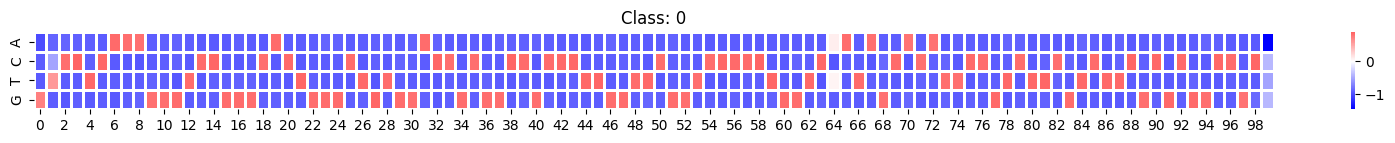

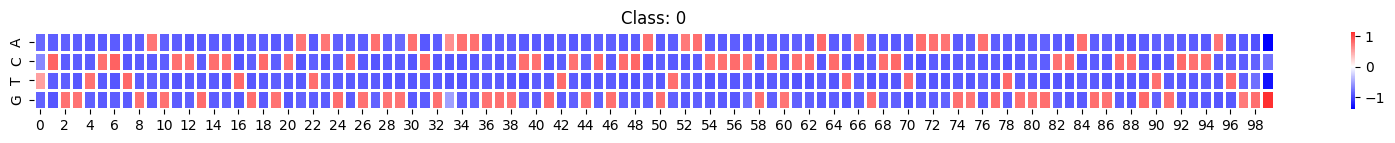

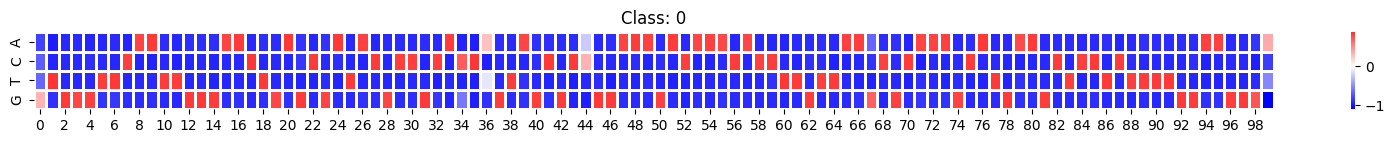

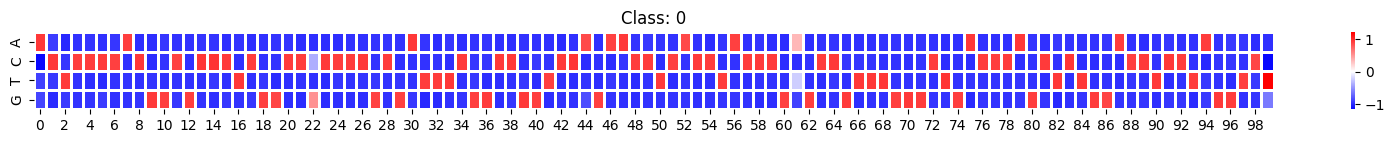

In [ ]:
model.eval()
sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, 16))
random_classes = sampled.to(device)
samples = sample(model, classes=random_classes, image_size=100, batch_size=16, channels=1, cond_weight=1)
n_print = 0
for image, class_show in zip(samples[-1], random_classes):
    if n_print < 4:
        plt.rcParams["figure.figsize"] = (20, 1)
        pd_seq = pd.DataFrame(image.reshape(4, 100))
        pd_seq.index = NUCLEOTIDES
        sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
        plt.title(f'Class: {class_show}')
        plt.show()
        plt.rcParams["figure.figsize"] = (2, 2)
        n_print = n_print + 1

In [ ]:
@torch.no_grad()
def p_sample_loop_t(model, classes, shape, cond_weight):
    device = next(model.parameters()).device
    timesteps = 10
    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    if classes is not None:
        n_sample = classes.shape[0]
        context_mask = torch.ones_like(classes).to(device)
        classes = classes.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 0.0
        sampling_fn = partial(p_sample_guided, classes=classes, cond_weight=cond_weight, context_mask=context_mask)
    else:
        sampling_fn = partial(p_sample)

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = sampling_fn(model, x=img, t=torch.full((b,), i, device=device, dtype=torch.long), t_index=i)
        imgs.append(img.cpu().numpy())
    return imgs


@torch.no_grad()
def sample_t(model, image_size, classes=None, batch_size=16, channels=3, cond_weight=0):
    return p_sample_loop_t(model, classes=classes, shape=(batch_size, channels, 4, image_size), cond_weight=cond_weight)

In [ ]:
def sampling_reverse_encoding(number_of_samples, specific_group=False, group_number=None, cond_weight_to_metric=0):
    """
    Stands for reverse encoding
    """
    final_sequences = []
    for n_a in tqdm(range(number_of_samples)):  # Use tqdm instead of tqdm_notebook
        sample_bs = 16
        if specific_group:
            sampled = torch.from_numpy(np.array([group_number] * sample_bs))
            print('specific')
        else:
            sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, sample_bs))

        random_classes = sampled.float().cuda()
        sampled_images = sample_t(
            model,
            classes=random_classes,
            image_size=100,
            batch_size=sample_bs,
            channels=1,
            cond_weight=cond_weight_to_metric,
        )
        for n_b, x in enumerate(sampled_images[-1]):
            seq_final = f'>seq_test_{n_a}_{n_b}\n' + ''.join(
                [NUCLEOTIDES[s] for s in np.argmax(x.reshape(4, 100), axis=0)]
            )
            final_sequences.append(seq_final)

    save_motifs_syn = open('synthetic_seqs_by_kan.fasta', 'w')

    save_motifs_syn.write('\n'.join(final_sequences))
    save_motifs_syn.close()

In [ ]:
%%capture
%%time
n = 100
synt_df = sampling_reverse_encoding(n)

In [ ]:
fasta_file_path = "/content/zdna2016_filter-norm_to_512.fasta"
with open(fasta_file_path, 'r') as fasta_file:
    fasta_lines = fasta_file.readlines()

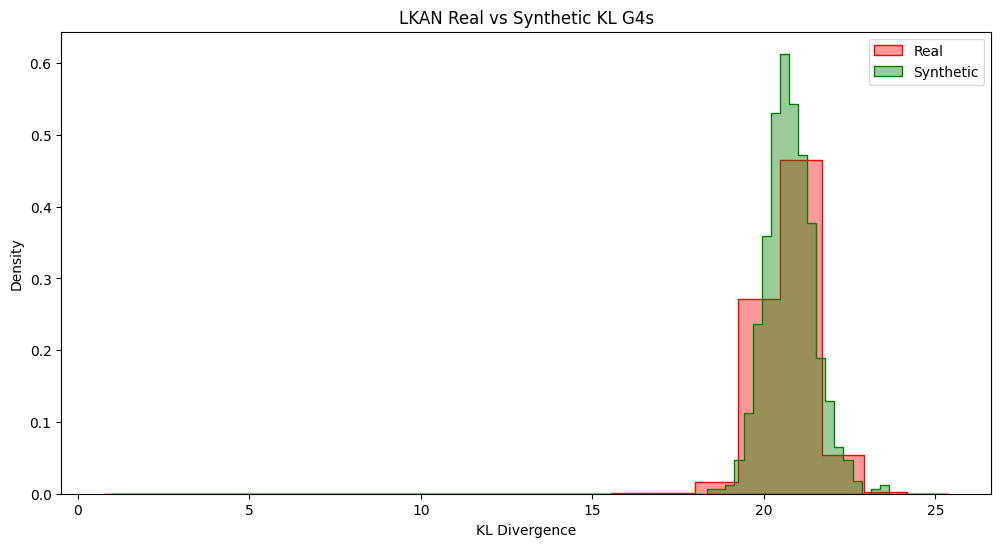

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(real_kl_divergence_scores, color='red', bins=20, label="Real", stat="density", element="step", alpha=0.4)
sns.histplot(fake_kl_divergence_scores, color='green', bins=20, label="Synthetic", stat="density", element="step", alpha=0.4)
plt.title('LKAN Real vs Synthetic KL G4s')
plt.xlabel('KL Divergence')
plt.ylabel('Density')
plt.legend()
plt.show()


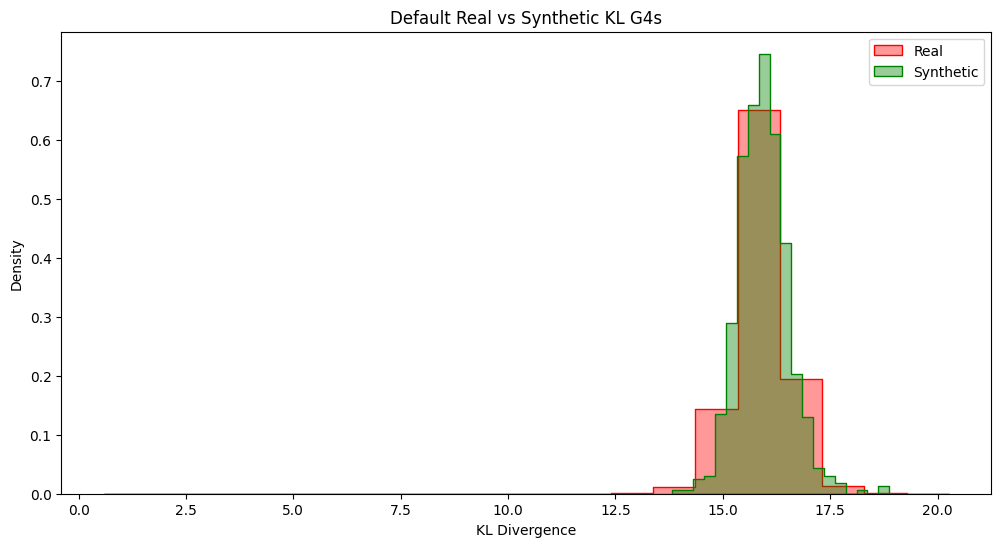

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(real_kl_divergence_scores, color='red', bins=20, label="Real", stat="density", element="step", alpha=0.4)
sns.histplot(fake_kl_divergence_scores, color='green', bins=20, label="Synthetic", stat="density", element="step", alpha=0.4)
plt.title('Default Real vs Synthetic KL G4s')
plt.xlabel('KL Divergence')
plt.ylabel('Density')
plt.legend()
plt.show()

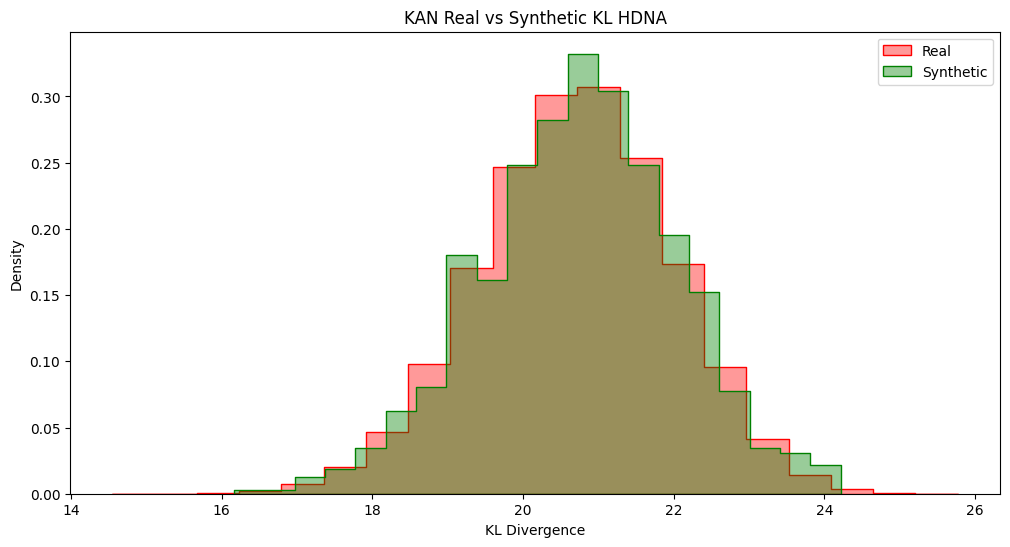

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(real_kl_divergence_scores, color='red', bins=20, label="Real", stat="density", element="step", alpha=0.4)
sns.histplot(fake_kl_divergence_scores, color='green', bins=20, label="Synthetic", stat="density", element="step", alpha=0.4)
plt.title('KAN Real vs Synthetic KL HDNA')
plt.xlabel('KL Divergence')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
# gc.collect()
# torch.cuda.empty_cache()

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

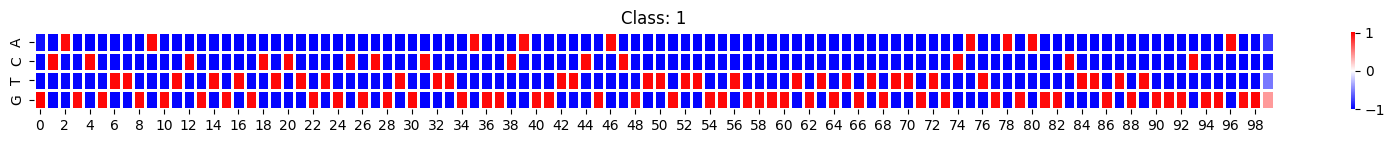

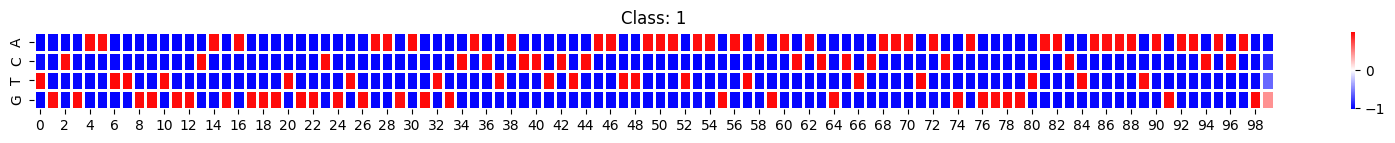

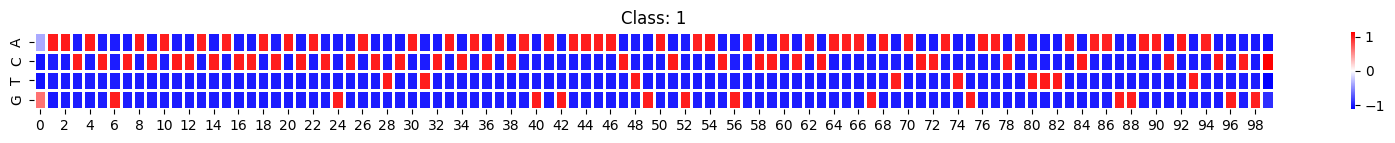

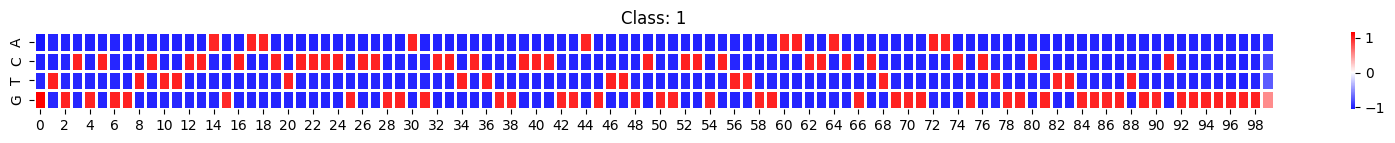

In [ ]:
model.eval()
sampled = torch.from_numpy(np.random.choice(raw_dataset["label"].values, 16))
random_classes = sampled.to(device)
samples = sample(model, classes=random_classes, image_size=100, batch_size=16, channels=1, cond_weight=1)
n_print = 0
for image, class_show in zip(samples[-1], random_classes):
    if n_print < 4:
        plt.rcParams["figure.figsize"] = (20, 1)
        pd_seq = pd.DataFrame(image.reshape(4, 100))
        pd_seq.index = NUCLEOTIDES
        sns.heatmap(pd_seq, linewidth=1, cmap='bwr', center=0)
        plt.title(f'Class: {class_show}')
        plt.show()
        plt.rcParams["figure.figsize"] = (2, 2)
        n_print = n_print + 1

In [ ]:
encoding_map = {"A": [1, 0, 0, 0], "T": [0, 1, 0, 0], "C": [0, 0, 1, 0], "G": [0, 0, 0, 1],
                "a": [1, 0, 0, 0], "t": [0, 1, 0, 0], "c": [0, 0, 1, 0], "g": [0, 0, 0, 1],
                "N": [0, 0, 0, 1]
                }



real_one_hot_encoded = [one_hot_encode(seq) for seq in real_sequences]
fake_one_hot_encoded = [one_hot_encode(seq) for seq in fake_sequences]
real_wasserstein_scores = [
    wasserstein_distance(real_one_hot_encoded[i].flatten(), real_one_hot_encoded[j].flatten())
    for i in range(len(real_one_hot_encoded))
    for j in range(i + 1, len(real_one_hot_encoded))
]

fake_wasserstein_scores = [
    wasserstein_distance(real_seq.flatten(), fake_seq.flatten())
    for real_seq, fake_seq in zip(real_one_hot_encoded, fake_one_hot_encoded)
]


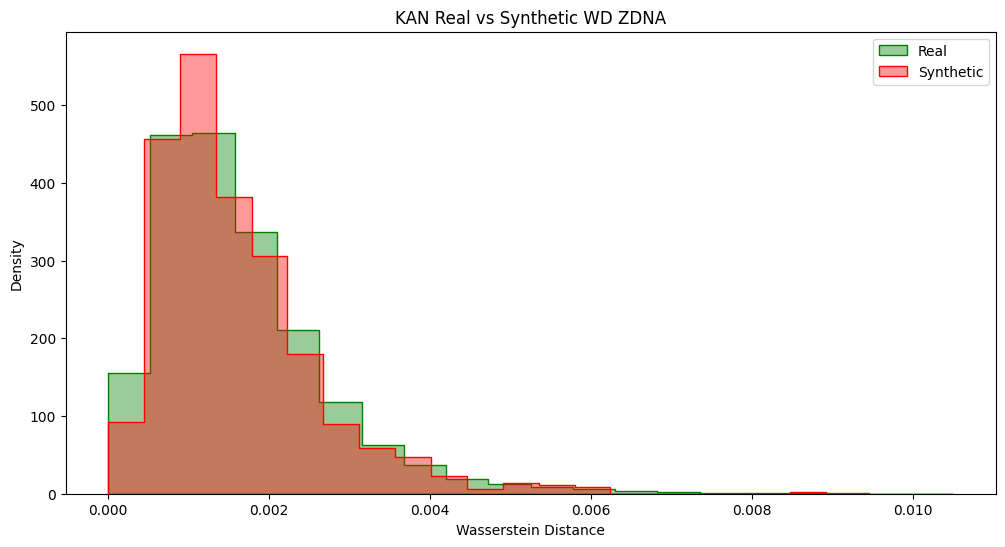

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(real_wasserstein_scores, color='green', bins=20, label="Real", stat="density", element="step", alpha=0.4)
sns.histplot(fake_wasserstein_scores, color='red', bins=20, label="Synthetic", stat="density", element="step", alpha=0.4)
plt.title(f'KAN Real vs Synthetic WD ZDNA')
plt.xlabel('Wasserstein Distance')
plt.ylabel('Density')
plt.legend()
plt.show()

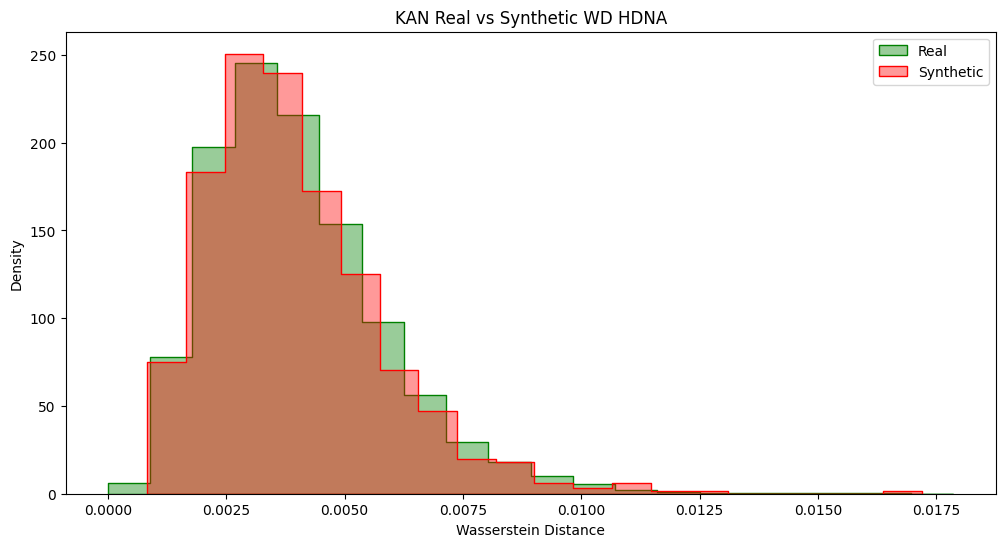

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(real_wasserstein_scores, color='green', bins=20, label="Real", stat="density", element="step", alpha=0.4)
sns.histplot(fake_wasserstein_scores, color='red', bins=20, label="Synthetic", stat="density", element="step", alpha=0.4)
plt.title(f'KAN Real vs Synthetic WD HDNA')
plt.xlabel('Wasserstein Distance')
plt.ylabel('Density')
plt.legend()
plt.show()

СKAN